2조 최종 코드 (김연진, 문지윤, 윤대웅, 이다경, 이승학)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Load the CSV file to inspect the contents
raw_data = pd.read_csv('../../bigfile/1주_실습데이터.csv')
data = raw_data.copy()

## 1. 데이터 전처리 및 모델 평가
1. 데이터 확인 (상관관계 분석 및 변수 간 시각화)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527000 entries, 0 to 526999
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X1      527000 non-null  float64
 1   X2      527000 non-null  float64
 2   X3      527000 non-null  float64
 3   X4      527000 non-null  float64
 4   X5      527000 non-null  float64
 5   X6      527000 non-null  float64
 6   X7      527000 non-null  float64
 7   X8      527000 non-null  float64
 8   X9      527000 non-null  float64
 9   X10     527000 non-null  float64
 10  X11     527000 non-null  float64
 11  X12     527000 non-null  float64
 12  X13     527000 non-null  float64
 13  X14     527000 non-null  float64
 14  X15     527000 non-null  float64
 15  X16     527000 non-null  float64
 16  X17     527000 non-null  float64
 17  X18     527000 non-null  float64
 18  X19     527000 non-null  float64
 19  X20     527000 non-null  float64
 20  Y       527000 non-null  int64  
dtypes: float64

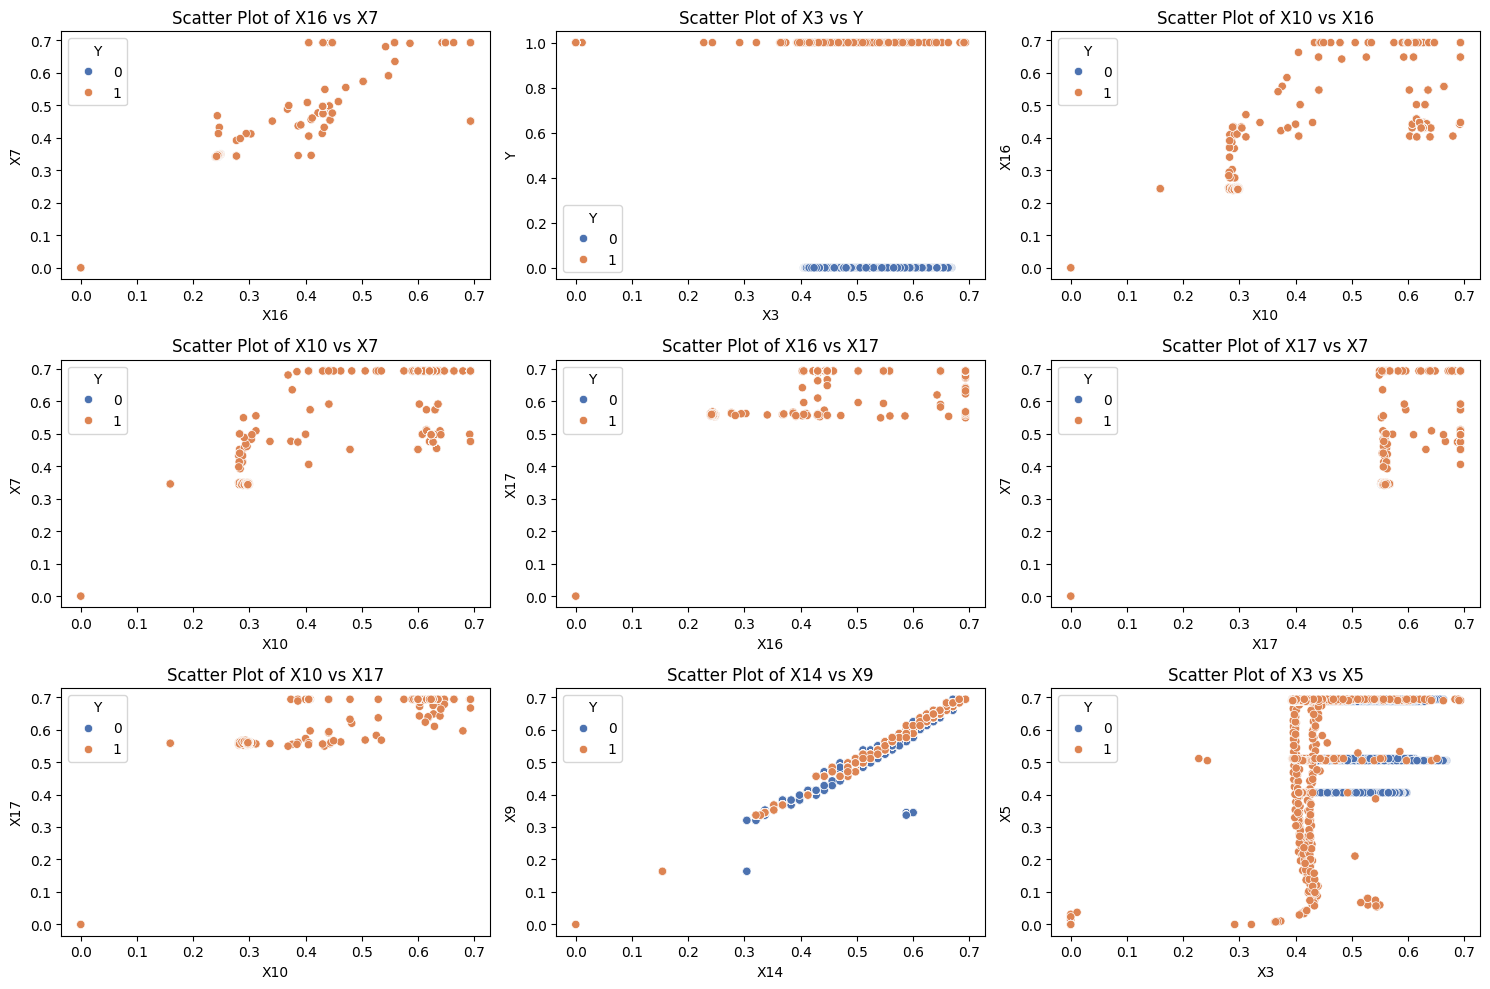

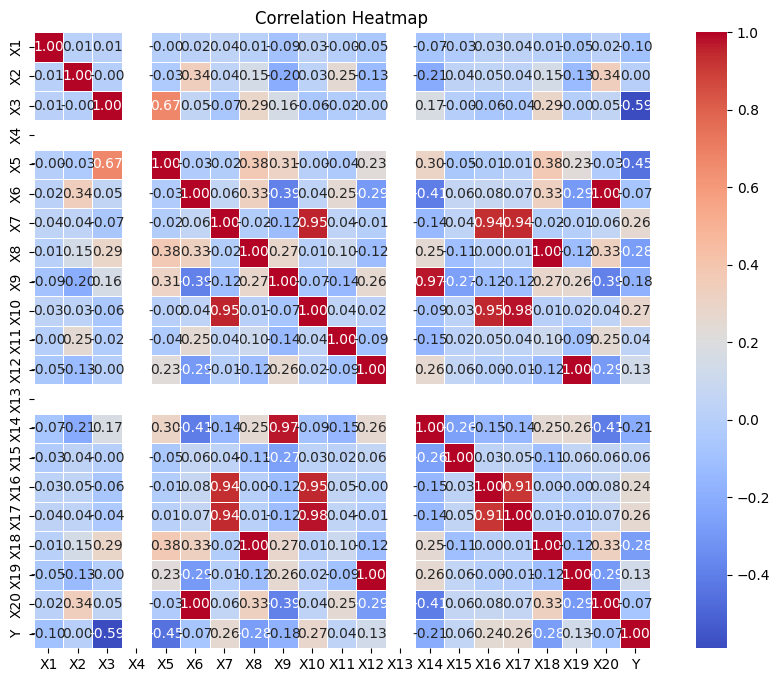

In [2]:
# 1. 데이터 확인
data.info() # 결측치 확인
data.describe()
data.head(10)

# Y 변수 (타겟 변수) 분포 확인
target_dist = data['Y'].value_counts()

# 상관관계 계산
correlation_matrix = data.corr()

# 상관관계 표 출력
print(correlation_matrix)

# 상관관계 행렬을 불러온 데이터프레임에서 계산
correlation_matrix = data.corr()

# 유의미한 상관관계 (상관계수 절댓값이 0.5 이상인 변수 쌍 찾기)
threshold = 0.5
significant_pairs = correlation_matrix[(correlation_matrix.abs() >= threshold) & (correlation_matrix != 1)]

# 유의미한 변수 쌍 목록 생성
significant_columns = significant_pairs.stack().index.tolist()

# 중복 제거 (예: (X1, Y)와 (Y, X1) 중복)
unique_pairs = set()
for pair in significant_columns:
    unique_pairs.add(tuple(sorted(pair)))

# 산점도 그리기
plt.figure(figsize=(15, 10))
for i, (var1, var2) in enumerate(unique_pairs):
    plt.subplot(3, 3, i + 1)  # 3x3 그리드에 산점도 배치
    sns.scatterplot(data=data, x=var1, y=var2, hue='Y', palette='deep')
    plt.title(f'Scatter Plot of {var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.tight_layout()
plt.show()

# 2. 히트맵 시각화
plt.figure(figsize=(12, 8))  # 히트맵 크기 설정
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

2. 고윳값(단일값) 확인 -> 있다면 삭제

In [3]:
data.nunique() # -> x4랑 x13이 값이 하나임을 확인

data['X13']
data['X4']
# -> 둘 다 제거

data = data.drop(columns=['X4', 'X13'])

3. 같은 정보를 가진 변수 확인 = 단일값 찾기 -> 있다면 삭제 (동일한 값을 가진 열 찾기)

In [4]:
# 동일한 값을 가진 열 쌍을 찾는 코드
identical_columns = []
columns = data.columns

# 각 열을 비교하여 동일한 값을 가진 열을 찾기
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        if data[columns[i]].equals(data[columns[j]]):
            identical_columns.append((columns[i], columns[j]))

# 결과 출력
identical_columns
# [('X6', 'X20'), ('X8', 'X18'), ('X12', 'X19')]
# 이런 경우에는 drop으로 둘 중에 하나만 제거 (x8, x6, x12 남기기)
data = data.drop(columns=['X6', 'X8', 'X12'])

4. IQR 방식에 따른 이상치 탐지

각 변수에서 탐지된 이상치 개수:
X1         0
X2      2535
X3     17363
X5     97541
X7      4916
X9     11033
X10     5279
X11     2417
X14     9759
X15    38230
X16     7728
X17     5726
X18    48884
X19      265
X20     1326
Y      57000
dtype: int64


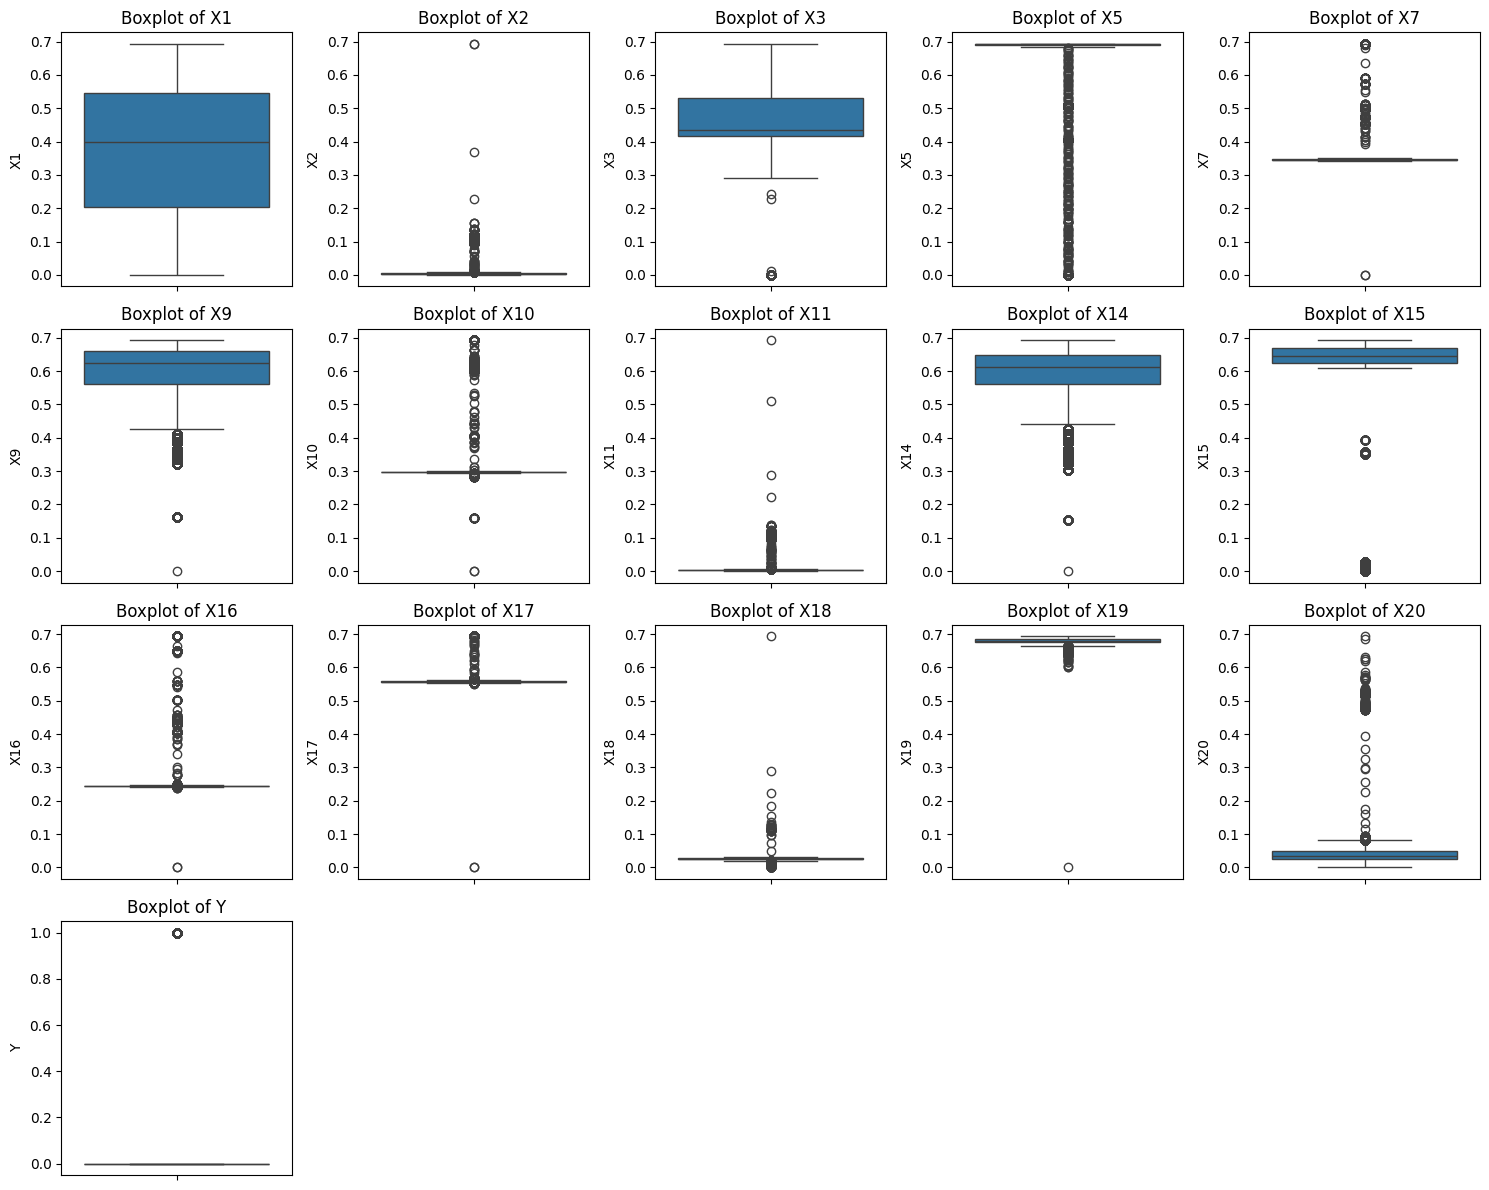

In [5]:
# IQR 방식으로 이상치 탐지
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# 이상치 탐지
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
print("각 변수에서 탐지된 이상치 개수:")
print(outliers)

# 박스플롯 그리기 - 직사각형 배치
num_cols = len(data.columns)
nrows = (num_cols // 5) + (num_cols % 5 > 0)  # 3열로 나눠서 배치
fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(15, 3*nrows))

# 데이터가 3개 미만인 경우를 대비
axes = axes.flatten()

# 각 변수에 대해 박스플롯 그리기
for i, col in enumerate(data.columns):
    sns.boxplot(data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# 빈 플롯 숨기기 (컬럼 수가 3의 배수가 아닐 때)
for i in range(len(data.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 2. 이상치 제거: 상/하위 0%~1%, 0.1% 간격으로 제거하는 함수 정의
# IQR 방식으로 이상치 탐지하는 함수
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    return outliers

# 이상치 제거 함수 (단계별 상하위 백분위수 기준 제거)
def remove_outliers_by_percentile(data, lower_percentile, upper_percentile):
    lower_bounds = data.quantile(lower_percentile)
    upper_bounds = data.quantile(upper_percentile)

    # 각 열의 값이 해당 백분위수 기준 안에 있는지 필터링
    cleaned_data = data.apply(lambda x: x[(x >= lower_bounds[x.name]) & (x <= upper_bounds[x.name])], axis=0)

    return cleaned_data.dropna()

# 0%부터 1%까지 0.1%씩 단계적으로 이상치 제거 및 탐지
step = 0.001  # 0.1%
percentiles = np.arange(0, 0.011, step)  # 0% ~ 1%까지의 백분위수

# 결과를 저장할 데이터프레임 생성
outliers_df = pd.DataFrame()

for perc in percentiles:
    # 현재 백분위수로 데이터 이상치 제거
    clean_data = remove_outliers_by_percentile(data, perc, 1-perc)

    # 이상치 개수 탐지
    outliers = detect_outliers(clean_data)

    # 결과를 데이터프레임에 추가 (백분위수와 함께)
    outliers_df[f'{perc*100:.1f}% 제거'] = outliers

5. 정규화: RobustScaler를 이용한 데이터 스케일링

In [6]:
def apply_scaling(clean_data, normalize=True):
    if normalize:
        scaler = RobustScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(clean_data), columns=clean_data.columns)
        return scaled_data
    return clean_data

6. 모델 학습 및 평가 함수 성능 평가

In [8]:
def evaluate_model_normalize(clean_data, model_type='XGB',normalize = True):
    X = clean_data.drop(columns=['Y'])
    y = clean_data['Y']

    X = apply_scaling(X, normalize)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 모델 선택
    if model_type == 'XGB':
        model = XGBClassifier()
    elif model_type == 'LGBM':
        model = LGBMClassifier()
    elif model_type == 'RF':
        model = RandomForestClassifier()

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return auroc, f1, recall, precision

def evaluate_model(clean_data, model_type='XGB', nomarlize = True):
    X = clean_data.drop(columns=['Y'])
    y = clean_data['Y']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # 타겟 변수 y의 클래스 비율을 학습 데이터와 테스트 데이터에 동일하게 유지

    # 모델 선택
    if model_type == 'XGB':
        model = XGBClassifier()
    elif model_type == 'LGBM':
        model = LGBMClassifier()
    elif model_type == 'RF':
        model = RandomForestClassifier()

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    auroc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return auroc, f1, recall, precision

X = clean_data.drop(columns=['Y'])
y = clean_data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clean_data

,X1,X2,X3,X5,X7,X9,X10,X11,X14,X15,X16,X17,X18,X19,X20,Y
0,0.202296,0.003560,0.411261,0.693147,0.343512,0.681974,0.295769,0.003053,0.681974,0.016330,0.242926,0.557461,0.028087,0.682731,0.036360,0
2,0.609621,0.001461,0.466186,0.693090,0.345032,0.647685,0.298255,0.001475,0.647685,0.648486,0.243602,0.559431,0.024502,0.685525,0.018944,0
3,0.074007,0.003072,0.535876,0.693147,0.347502,0.587787,0.296057,0.002462,0.575364,0.632563,0.246078,0.556761,0.025393,0.677980,0.031475,0
4,0.198356,0.007020,0.416238,0.686838,0.347441,0.537143,0.298167,0.005314,0.537143,0.671124,0.245505,0.561695,0.028450,0.673286,0.061888,0
5,0.643198,0.005712,0.495198,0.693147,0.347051,0.587787,0.295037,0.004415,0.587787,0.679690,0.245640,0.555462,0.028236,0.674294,0.053023,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526988,0.034406,0.003570,0.400308,0.693147,0.345606,0.575364,0.295609,0.003548,0.562785,0.616268,0.243208,0.555734,0.018102,0.682668,0.030943,1
526991,0.399744,0.005000,0.000000,0.000000,0.346830,0.483797,0.295769,0.004600,0.483797,0.613330,0.244222,0.556228,0.017663,0.679031,0.039953,1
526992,0.049564,0.003339,0.395505,0.693147,0.342847,0.647685,0.296249,0.003255,0.635989,0.637721,0.241177,0.555280,0.024778,0.685914,0.029886,1
526993,0.525100,0.003489,0.400308,0.688810,0.342847,0.635989,0.298167,0.003405,0.624154,0.652919,0.241177,0.557501,0.024948,0.686331,0.030759,1


7. 모든 이상치 비율에 대해 실행하고, XGB 성능평가

In [9]:
results = []
model_types = ['XGB']

for i in np.arange(0, 0.011, 0.001):
    clean_data = remove_outliers_by_percentile(data, i, 1-i)

    for normalize in [True, False]:
            if normalize == True:
                        for model_type in model_types:
                                    auroc, f1, recall, precision = evaluate_model_normalize(clean_data, model_type, normalize)
                                    results.append({
                                    'Outlier_Percentage': i,
                                    'Normalized': normalize,
                                    'Model_Type': model_type,
                                    'AUROC': auroc,
                                    'F1-Score': f1,
                                    'Recall': recall,
                                    'Precision': precision
                                    })
            else:
                        for model_type in model_types:
                                    auroc, f1, recall, precision = evaluate_model(clean_data, model_type)
                                    results.append({
                                    'Outlier_Percentage': i,
                                    'Normalized': normalize,
                                    'Model_Type': model_type,
                                    'AUROC': auroc,
                                    'F1-Score': f1,
                                    'Recall': recall,
                                    'Precision': precision
                                    })


# 결과 출력 (테이블 형태로)
results_df = pd.DataFrame(results)
print(results_df)

    Outlier_Percentage  Normalized Model_Type     AUROC  F1-Score    Recall  \
0                0.000        True        XGB  0.999785  0.998507  0.997193   
1                0.000       False        XGB  0.999785  0.998507  0.997193   
2                0.001        True        XGB  0.999771  0.999099  0.998289   
3                0.001       False        XGB  0.999771  0.999099  0.998289   
4                0.002        True        XGB  0.999779  0.998534  0.997261   
5                0.002       False        XGB  0.999779  0.998534  0.997261   
6                0.003        True        XGB  0.999841  0.998854  0.997909   
7                0.003       False        XGB  0.999841  0.998854  0.997909   
8                0.004        True        XGB  0.999873  0.998881  0.998068   
9                0.004       False        XGB  0.999873  0.998881  0.998068   
10               0.005        True        XGB  0.999899  0.998947  0.998211   
11               0.005       False        XGB  0.999

## 2. SHAP 분석을 통한 모델 해석
1. 이상치 제거 및 XGBoost 모델 학습

In [10]:
import shap

results = []
model_types = ['XGB']

for i in np.arange(0, 0.011, 0.001):
    clean_data = remove_outliers_by_percentile(data, i, 1-i)

    for normalize in [True, False]:
        for model_type in model_types:
            auroc, f1, recall, precision = evaluate_model(clean_data, model_type, normalize)
            results.append({
                'Outlier_Percentage': i,
                'Normalized': normalize,
                'Model_Type': model_type,
                'AUROC': auroc,
                'F1-Score': f1,
                'Recall': recall,
                'Precision': precision
            })

# 결과 출력 (테이블 형태로)
results_df = pd.DataFrame(results)
print(results_df)

# XGBoost 모델 정의 및 학습
X = clean_data.drop(columns=['Y'])  # 'Y'는 타겟 변수
y = clean_data['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier()  # XGBoost 모델 정의
model.fit(X_train, y_train)  # 모델 학습

# SHAP 분석
explainer = shap.TreeExplainer(model)  # Tree 모델용 Explainer
shap_values = explainer.shap_values(X_test)

    Outlier_Percentage  Normalized Model_Type     AUROC  F1-Score    Recall  \
0                0.000        True        XGB  0.999785  0.998507  0.997193   
1                0.000       False        XGB  0.999785  0.998507  0.997193   
2                0.001        True        XGB  0.999771  0.999099  0.998289   
3                0.001       False        XGB  0.999771  0.999099  0.998289   
4                0.002        True        XGB  0.999779  0.998534  0.997261   
5                0.002       False        XGB  0.999779  0.998534  0.997261   
6                0.003        True        XGB  0.999841  0.998854  0.997909   
7                0.003       False        XGB  0.999841  0.998854  0.997909   
8                0.004        True        XGB  0.999873  0.998881  0.998068   
9                0.004       False        XGB  0.999873  0.998881  0.998068   
10               0.005        True        XGB  0.999899  0.998947  0.998211   
11               0.005       False        XGB  0.999

1-1 전체 변수의 중요도 시각화 (Summary Plot)

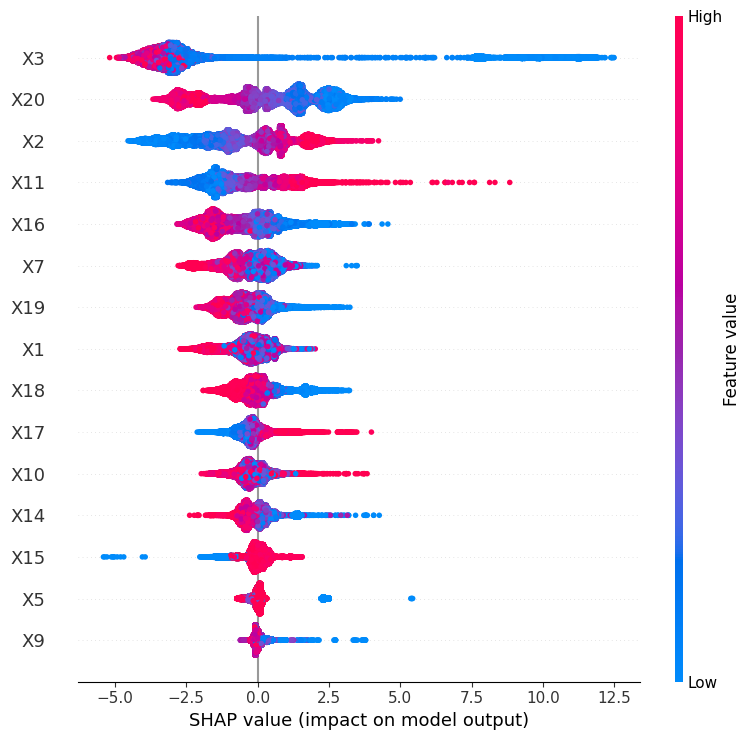

In [11]:
shap.summary_plot(shap_values, X_test)

1-2 각 변수의 SHAP 값 분포 시각화 (Bar Plot)

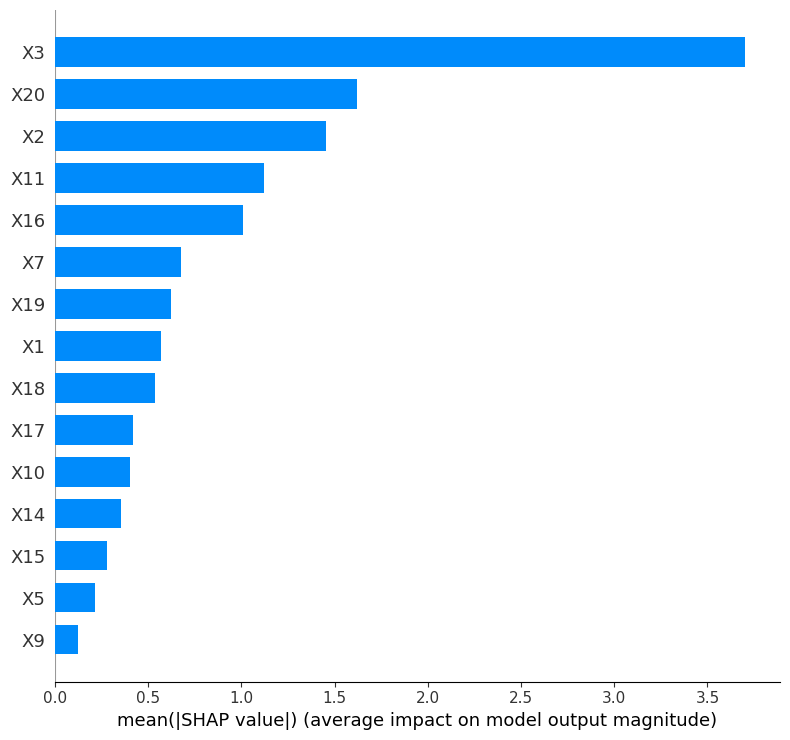

In [12]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

1-3  특정 데이터 샘플에 대한 Force Plot (개별 예측 설명)

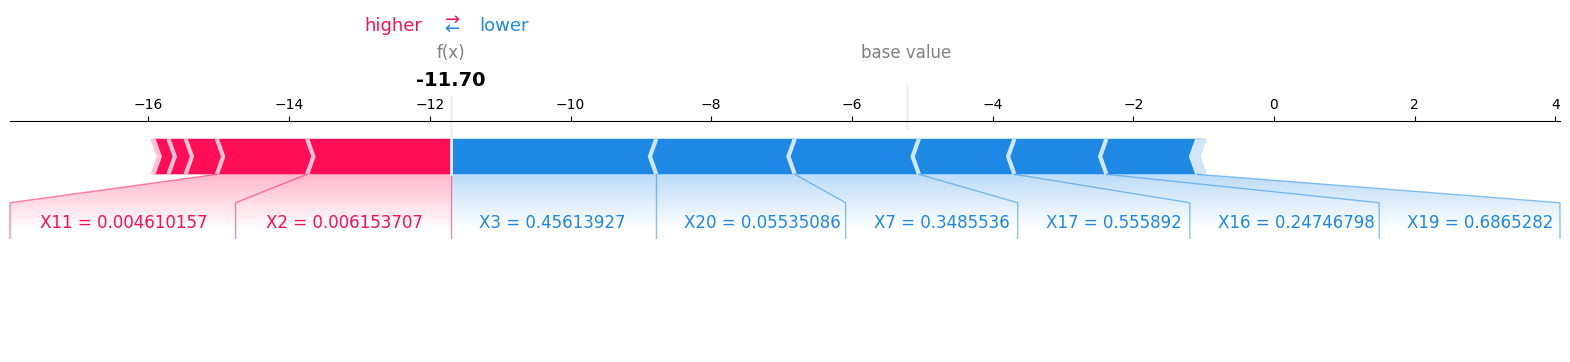

In [13]:
sample_idx = 10  # 예시로 10번째 샘플에 대한 예측 설명
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_test.iloc[sample_idx, :], matplotlib=True)

1-4 특정 변수에 대한 Partial Dependence Plot (PDP)

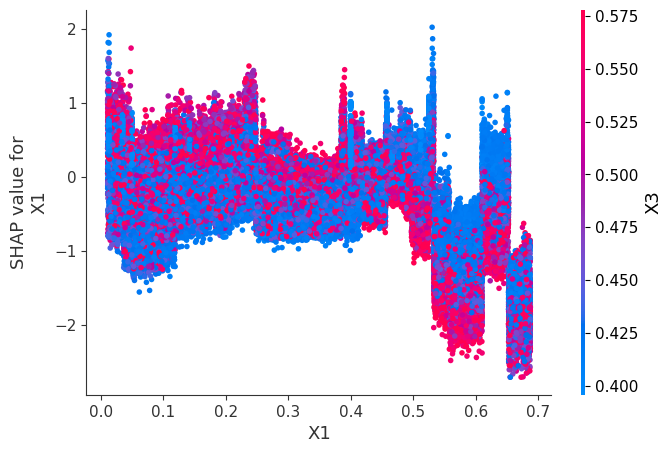

In [14]:
# 예시로 'X1' 변수에 대한 SHAP 분석
shap.dependence_plot('X1', shap_values, X_test)

2. 의사결정나무

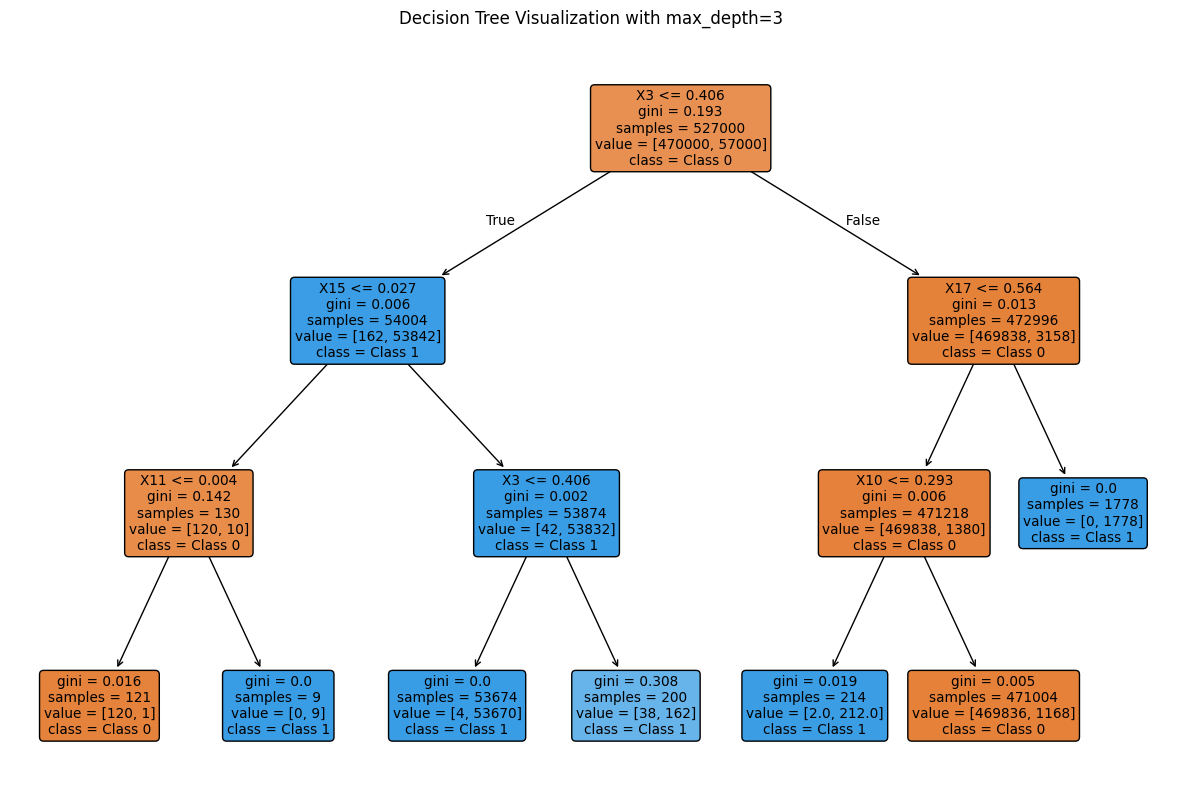

X3 <= 0.406일 때 Y 값 분포:
Y
1    53679
0       47
Name: count, dtype: int64

X3 > 0.406일 때 Y 값 분포:
Y
0    469953
1      3321
Name: count, dtype: int64


In [15]:
# 원본 데이터 나누기
X = raw_data.drop(columns=['Y'])
y = raw_data['Y']

# 의사결정나무 모델 학습 (최대 깊이를 제한해서 트리가 너무 복잡해지지 않도록 함)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X, y)

# 의사결정나무 시각화 (큰 이미지 크기로 설정)
plt.figure(figsize=(15, 10))  # 이미지 크기를 크게 설정
plot_tree(tree_model, feature_names=X.columns, class_names=['Class 0', 'Class 1'], filled=True, rounded=True)
plt.title("Decision Tree Visualization with max_depth=3")
plt.show()

# X3이 0.406 이하일 때의 Y 값 분포 확인
below_threshold = data[data['X3'] <= 0.406]['Y'].value_counts()

# X3이 0.406보다 클 때의 Y 값 분포 확인
above_threshold = data[data['X3'] > 0.406]['Y'].value_counts()

# 결과 출력
print("X3 <= 0.406일 때 Y 값 분포:")
print(below_threshold)

print("\nX3 > 0.406일 때 Y 값 분포:")
print(above_threshold)